In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras import Model

##Data Prep

In [2]:
dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/tf_flowers/incomplete.W5KTPH_3.0.1/tf_flowers-train.tfrecord*...:   0%|   …

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [3]:
test_set = tfds.load("tf_flowers", split="train[0:10%]", as_supervised=True)
valid_set = tfds.load("tf_flowers", split="train[10%:25%]", as_supervised=True)
train_set = tfds.load("tf_flowers", split="train[25%:100%]", as_supervised=True)

##CNN Model

In [4]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    return resized_image, label

def augment(image, label):
    image, label = preprocess(image, label)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_saturation(image, 0.5, 1.5)
    image = tf.image.random_brightness(image, 0.2)
    return image, label

##Pipelining

In [5]:
batch_size = 32
train_set = train_set.shuffle(1000)
train_set = train_set.map(augment, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(1)
valid_set = valid_set.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(1)
test_set = test_set.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(1)

###Residual Unit

In [6]:
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            keras.layers.Conv2D(filters, 3, strides=strides, padding="same", use_bias=False),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv2D(filters, 3, strides=1, padding="same", use_bias=False),
            keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                keras.layers.Conv2D(filters, 1, strides=strides, padding="same", use_bias=False),
                keras.layers.BatchNormalization()
            ]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

##Build Model

In [7]:
custom_resnet_model = keras.models.Sequential()
custom_resnet_model.add(keras.layers.Conv2D(64, 7, strides=2, input_shape=[224, 224, 3], padding="same", use_bias=False))
custom_resnet_model.add(keras.layers.BatchNormalization())
custom_resnet_model.add(keras.layers.Activation("relu"))
custom_resnet_model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    custom_resnet_model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
custom_resnet_model.add(keras.layers.GlobalAvgPool2D())
custom_resnet_model.add(keras.layers.Flatten())
custom_resnet_model.add(keras.layers.Dense(n_classes, activation="softmax"))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
custom_resnet_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 112, 112, 64)   │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit (ResidualUnit)    │ (None, 56, 56, 64)     │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_1 (ResidualUnit)  │ (None, 56, 56, 64)     │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_2 (ResidualUnit)  │ (None, 56, 56, 64)     │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_3 (ResidualUnit)  │ (None, 28, 28, 128)    │       230,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_4 (ResidualUnit)  │ (None, 28, 28, 128)    │       295,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_5 (ResidualUnit)  │ (None, 28, 28, 128)    │       295,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_6 (ResidualUnit)  │ (None, 28, 28, 128)    │       295,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_7 (ResidualUnit)  │ (None, 14, 14, 256)    │       920,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_8 (ResidualUnit)  │ (None, 14, 14, 256)    │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_9 (ResidualUnit)  │ (None, 14, 14, 256)    │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_10 (ResidualUnit) │ (None, 14, 14, 256)    │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_11 (ResidualUnit) │ (None, 14, 14, 256)    │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_12 (ResidualUnit) │ (None, 14, 14, 256)    │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_13 (ResidualUnit) │ (None, 7, 7, 512)      │     3,676,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_14 (ResidualUnit) │ (None, 7, 7, 512)      │     4,722,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_15 (ResidualUnit) │ (None, 7, 7, 512)      │     4,722,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,304,261 (81.27 MB)

 Trainable params: 21,287,237 (81.20 MB)

 Non-trainable params: 17,024 (66.50 KB)

In [9]:
base_model = keras.applications.xception.Xception(weights="imagenet",include_top=False)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
for layer in base_model.layers:
    layer.trainable = False

##Training Model

In [11]:
inputs = keras.layers.Input(shape=(224, 224, 3))
preprocessed_input = keras.applications.xception.preprocess_input(inputs)
avg = keras.layers.GlobalAveragePooling2D()(base_model(preprocessed_input))
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
transfer_learning_model = keras.Model(inputs=inputs, outputs=output)

In [12]:
optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9)
transfer_learning_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history_head = transfer_learning_model.fit(train_set, epochs=5, validation_data=valid_set)

Epoch 1/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 35s 243ms/step - accuracy: 0.7019 - loss: 1.6851 - val_accuracy: 0.8657 - val_loss: 1.2179
Epoch 2/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 22s 140ms/step - accuracy: 0.8755 - loss: 0.8567 - val_accuracy: 0.8693 - val_loss: 1.1510
Epoch 3/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 20s 140ms/step - accuracy: 0.9013 - loss: 0.6941 - val_accuracy: 0.8566 - val_loss: 1.3709
Epoch 4/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 20s 132ms/step - accuracy: 0.9209 - loss: 0.5239 - val_accuracy: 0.8385 - val_loss: 1.5543
Epoch 5/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 21s 142ms/step - accuracy: 0.9282 - loss: 0.3577 - val_accuracy: 0.8312 - val_loss: 1.4851


In [13]:
for layer in base_model.layers:
    layer.trainable = True

In [14]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9) # Gunakan learning rate yang jauh lebih kecil
transfer_learning_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history_fine_tune = transfer_learning_model.fit(train_set, epochs=5, validation_data=valid_set)

Epoch 1/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 72s 474ms/step - accuracy: 0.7922 - loss: 0.8256 - val_accuracy: 0.8058 - val_loss: 1.1833
Epoch 2/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 61s 447ms/step - accuracy: 0.9391 - loss: 0.1855 - val_accuracy: 0.9093 - val_loss: 0.3693
Epoch 3/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 41s 447ms/step - accuracy: 0.9825 - loss: 0.0613 - val_accuracy: 0.9129 - val_loss: 0.3281
Epoch 4/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 42s 465ms/step - accuracy: 0.9883 - loss: 0.0543 - val_accuracy: 0.9056 - val_loss: 0.3830
Epoch 5/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 39s 449ms/step - accuracy: 0.9878 - loss: 0.0443 - val_accuracy: 0.9129 - val_loss: 0.3388


In [15]:
transfer_learning_model.evaluate(test_set)

12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 465ms/step - accuracy: 0.9317 - loss: 0.2488


[0.2552639842033386, 0.9346048831939697]

##Evaluasi

In [21]:
for images, labels in test_set.take(1):
    sample_image = images[0]
    break

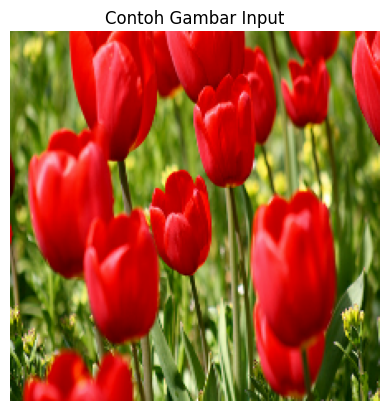

In [22]:
plt.imshow(sample_image.numpy().astype("uint8"))
plt.title("Contoh Gambar Input")
plt.axis("off")
plt.show()

In [23]:
layer_outputs = [layer.output for layer in base_model.layers[:20]]
activation_model = Model(inputs=base_model.input, outputs=layer_outputs)

In [24]:
# Ubah dimensi gambar dan preprocess input sesuai model Xception
img_tensor = tf.expand_dims(sample_image, axis=0)  # [1, 224, 224, 3]
preprocessed_img = keras.applications.xception.preprocess_input(img_tensor)

In [25]:
# Hitung activations
activations = activation_model.predict(preprocessed_img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [26]:
# Visualisasikan feature map dari layer tertentu (misalnya layer ke-5)
layer_idx = 5
feature_maps = activations[layer_idx]
n_features = feature_maps.shape[-1]

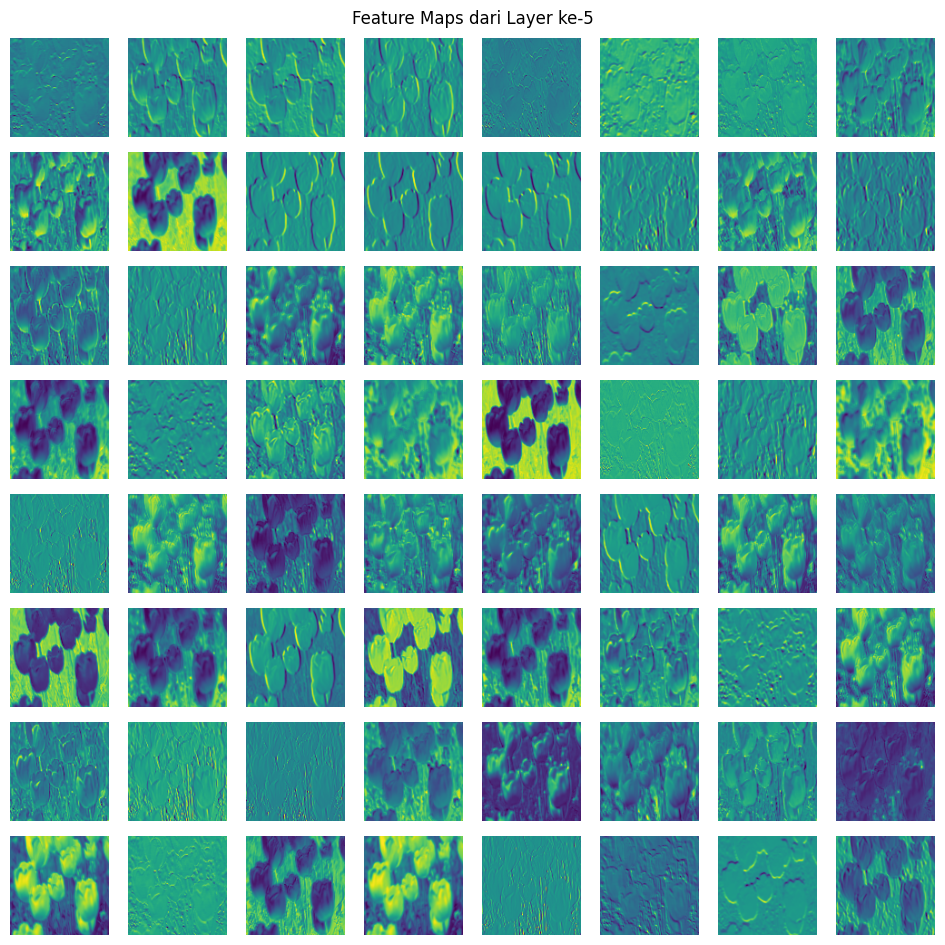

In [27]:
# Tentukan grid visualisasi (misalnya 8x8 jika n_features > 64)
size = feature_maps.shape[1]
n_cols = 8
n_rows = n_features // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 1.2, n_rows * 1.2))
for i in range(n_rows):
    for j in range(n_cols):
        ax = axes[i][j]
        ax.imshow(feature_maps[0, :, :, i * n_cols + j], cmap="viridis")
        ax.axis("off")
plt.suptitle(f"Feature Maps dari Layer ke-{layer_idx}")
plt.tight_layout()
plt.show()